In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.3-bin-hadoop2.7/
spark-3.0.3-bin-hadoop2.7/NOTICE
spark-3.0.3-bin-hadoop2.7/kubernetes/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/Dockerfile
spark-3.0.3-bin-hadoop2.7/jars/
spark-3.0.3-bin-hadoop2.7/jars/jacks

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [3]:
caseDetail = spark.read.option("inferSchema", True).csv("Dataset/Query and Visualization/CaseDetail.csv", header=True)
caseHeader = spark.read.option("inferSchema", True).csv("Dataset/Query and Visualization/CaseHeader.csv", header=True)
msCaseType = spark.read.option("inferSchema", True).csv("Dataset/Query and Visualization/MsCaseType.csv", header=True)
msPolice = spark.read.option("inferSchema", True).csv("Dataset/Query and Visualization/MsPolice.csv", header=True)
msPoliceOffice = spark.read.option("inferSchema", True).csv("Dataset/Query and Visualization/MsPoliceOffice.csv", header=True)
msVictim = spark.read.option("inferSchema", True).csv("Dataset/Query and Visualization/MsVictim.csv", header=True)

In [4]:
caseDetail.registerTempTable("CaseDetail")
caseHeader.registerTempTable("CaseHeader")
msCaseType.registerTempTable("MsCaseType")
msPolice.registerTempTable("MsPolice")
msPoliceOffice.registerTempTable("MsPoliceOffice")
msVictim.registerTempTable("MsVictim")

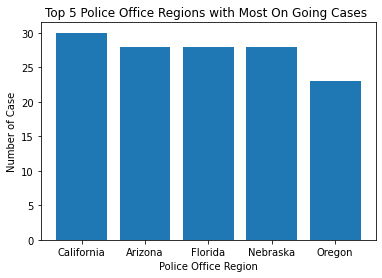

In [5]:
import matplotlib.pyplot as plt

res1 = spark.sql("""SELECT PoliceOfficeRegion, COUNT(*) AS CaseCount FROM CaseHeader ch 
                    JOIN CaseDetail cd ON ch.CaseID = cd.CaseID 
                    JOIN MsPolice mp ON cd.PoliceID = mp.PoliceID
                    JOIN MsPoliceOffice mpo ON mp.PoliceOfficeID = mpo.PoliceOfficeID 
                    WHERE CaseStatus = "On Going" 
                    GROUP BY PoliceOfficeRegion 
                    ORDER BY COUNT(*) DESC 
                    LIMIT 5
                  """)

res1 = res1.toPandas()
plt.title("Top 5 Police Office Regions with Most On Going Cases ")
plt.bar(res1["PoliceOfficeRegion"], res1["CaseCount"])
plt.xlabel("Police Office Region")
plt.ylabel("Number of Case")
plt.show()

Text(0, 0.5, 'Number of Victim')

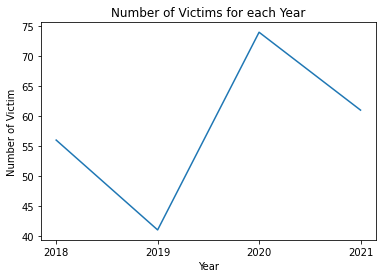

In [6]:
res2 = spark.sql("""SELECT YEAR(CaseDate) as Year, COUNT(*) as VictimCount FROM MsVictim mv 
                    JOIN CaseHeader ch ON mv.CaseID = ch.CaseID 
                    JOIN CaseDetail cd ON ch.CaseID = cd.CaseID 
                    JOIN MsPolice mp ON cd.PoliceID = mp.PoliceID 
                    JOIN MsPoliceOffice mpo ON mp.PoliceOfficeID = mpo.PoliceOfficeID 
                    WHERE PoliceOfficeRegion IN ("Nevada", "Washington", "Oregon", "California") 
                    GROUP BY YEAR(CaseDate)
                  """)

res2 = res2.toPandas()
plt.title("Number of Victims for each Year")
plt.plot(res2["VictimCount"])
plt.xticks(range(len(res2["Year"])), res2["Year"])
plt.xlabel("Year")
plt.ylabel("Number of Victim")

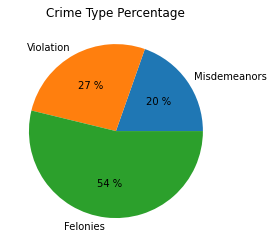

In [7]:
res3 = spark.sql("""SELECT COUNT(*) AS VictimCount, 
                    CASE
                        WHEN CaseTypeName IN ("Robbery", "Drug", "Burglary") THEN "Violation"
                        WHEN CaseTypeName IN ("Fraud and Scam", "Family Violance", "White-Colar Crime") THEN "Misdemeanors"
                        ELSE "Felonies"
                    END AS CrimeType
                    FROM MsVictim mv JOIN CaseHeader ch ON mv.CaseID = ch.CaseID 
                    JOIN MsCaseType mct ON ch.CaseTypeID = mct.CaseTypeID 
                    GROUP BY CrimeType 
                    HAVING COUNT(*) > 50
                  """)

res3 = res3.toPandas()
plt.title("Crime Type Percentage")
plt.pie(res3["VictimCount"], labels = res3["CrimeType"], autopct = "%.0f %%")
plt.show()